**Step 1: Import libraries **

In [6]:
from IPython import get_ipython
from IPython.display import display
# %%
# %%
from IPython import get_ipython
from IPython.display import display
# %%
!pip install albumentations
!pip install nibabel
!pip install opencv-python
!pip install segmentation_models_pytorch # Includes UNet, DeepLabV3+, etc.
!pip install torch torchvision torchaudio
!pip install tensorflow # Keep if you need it for other parts, but not for these models

import nibabel as nib
from torch.utils.data import Dataset
import tensorflow as tf # Keep if needed
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings

# Import models from segmentation_models_pytorch
import segmentation_models_pytorch as smp

print(f"Imports done")


Imports done


Step 2 : All helper functions and DataLoader

In [7]:
from google.colab import drive
drive.mount('/content/drive')
# 1. Set up paths and parameters
DATA_DIR = "/content/drive/My Drive/data/ISLES-2022"  # or your actual data folder path
N_MODELS = 1 # Train 3 models for the ensemble
EPOCHS = 1 # Reduce epochs for testing, increase for proper training
BATCH_SIZE = 2 # Reduce batch size due to model complexity and 3D data
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_paths_dict = {}


print("Using :", DEVICE)
# ...existing code...

TARGET_SHAPE = (64, 64, 64)  # Choose a shape your GPU can handle - might need adjustment for 3D


# Helper functions (Your existing code)
def dice_loss(pred, target, smooth=1.):
    pred = pred.reshape(-1)
    target = target.reshape(-1)
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))

def dice_score(pred, target, smooth=1.):
    pred = pred.reshape(-1)
    target = target.reshape(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def plot_sample(x, y, pred, channel=0):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Input (selected channel)")
    plt.imshow(x[channel].cpu(), cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(y.squeeze().cpu(), cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(pred.squeeze().cpu(), cmap='gray')
    plt.axis('off')
    plt.show()


def safe_unsqueeze_mask(y):
    # Ensure mask is [B, 1, D, H, W]
    if y.ndim == 4:
        y = y.unsqueeze(1)
    elif y.ndim == 5 and y.shape[1] != 1:
        # If mask has extra channels, take the first
        y = y[:, :1, ...]
    elif y.ndim < 4:
        raise ValueError(f"Mask shape too small: {y.shape}")
    return y

# ...existing code...
def pad_or_crop_to_shape_2d(x, target_shape_2d):
    # x: [B, C, H, W]
    _, _, H, W = x.shape
    tH, tW = target_shape_2d
    # Pad
    pad_h_before = (tH - H) // 2
    pad_h_after = tH - H - pad_h_before
    pad_w_before = (tW - W) // 2
    pad_w_after = tW - W - pad_w_before

    # Padding order for F.pad is (W_left, W_right, H_top, H_bottom) for 4D
    x = F.pad(x, [pad_w_before, pad_w_after, pad_h_before, pad_h_after])

    # Crop (only if needed, padding should handle this)
    x = x[:, :, :tH, :tW]
    return x
# Make sure to include the pad_or_crop_to_shape helper function:
def pad_or_crop_to_shape(x, target_shape):
    # x: [B, C, D, H, W]
    _, _, D, H, W = x.shape
    tD, tH, tW = target_shape
    # Pad
    pad_d_before = (tD - D) // 2
    pad_d_after = tD - D - pad_d_before
    pad_h_before = (tH - H) // 2
    pad_h_after = tH - H - pad_h_before
    pad_w_before = (tW - W) // 2
    pad_w_after = tW - W - pad_w_before

    # Padding order is (W_left, W_right, H_top, H_bottom, D_front, D_back) for 5D
    x = F.pad(x, [pad_w_before, pad_w_after, pad_h_before, pad_h_after, pad_d_before, pad_d_after])

    # Crop (only if needed, padding should handle this)
    x = x[:, :, :tD, :tH, :tW]
    return x


# Evaluation Metrics (Add AVD and F1 score functions here - if you have them)
def absolute_volume_difference(pred, target):
    # Implement AVD calculation
    # Example (assuming pred and target are binary tensors):
    pred_volume = torch.sum(pred)
    target_volume = torch.sum(target)
    if target_volume == 0: # Avoid division by zero
        return float('inf') if pred_volume > 0 else 0.0
    avd = torch.abs(pred_volume - target_volume) / target_volume * 100
    return avd.item()


def lesion_wise_f1_score(pred, target):
    # Implement lesion-wise F1 score calculation
    # This requires identifying individual lesions. A common approach is
    # to use connected components analysis on the ground truth and predictions.
    # This is more complex and requires libraries like SciPy or OpenCv.
    # For a simple pixel-wise F1, you can calculate that.

    # Simple pixel-wise F1:
    pred = pred.reshape(-1).bool()
    target = target.reshape(-1).bool()

    tp = (pred & target).sum().item()
    fp = (pred & ~target).sum().item()
    fn = (~pred & target).sum().item()

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

    return f1


def pad_or_crop_5d(x, target_shape):
    # x: [B, C, D, H, W] or [B, 1, D, H, W]
    _, _, D, H, W = x.shape
    tD, tH, tW = target_shape
    # Pad
    pad_d = max(tD - D, 0)
    pad_h = max(tH - H, 0)
    pad_w = max(tW - W, 0)
    x = F.pad(x, [0, pad_w, 0, pad_h, 0, pad_d])
    # Crop
    x = x[:, :, :tD, :tH, :tW]
    return x


# ...existing code...

def safe_pad_or_crop(x, target_shape):
    # Accepts [B, C, D, H, W] or [B, D, H, W] or [C, D, H, W]
    if x.ndim == 4:
        x = x.unsqueeze(0)  # Add batch dim if missing
    if x.ndim == 5:
        _, _, D, H, W = x.shape
        tD, tH, tW = target_shape
        pad_d = max(tD - D, 0)
        pad_h = max(tH - H, 0)
        pad_w = max(tW - W, 0)
        x = F.pad(x, [0, pad_w, 0, pad_h, 0, pad_d])
        x = x[:, :, :tD, :tH, :tW]
    else:
        raise ValueError(f"Input shape not supported: {x.shape}")
    return x

# %%
class ISLESDataset3D(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        print(f"entering 3D samples")
        mask_root = os.path.join(root_dir, "derivatives")
        for subject in os.listdir(root_dir):
            if subject.startswith("sub-"):
                ses_dir = os.path.join(root_dir, subject, "ses-0001")
                if os.path.exists(ses_dir):
                    dwi_dir = os.path.join(ses_dir, "dwi")
                    anat_dir = os.path.join(ses_dir, "anat")

                    # Look for both dwi and adc files in the dwi directory
                    dwi_files = [f for f in os.listdir(dwi_dir) if f.endswith("_dwi.nii.gz")]
                    adc_files = [f for f in os.listdir(dwi_dir) if f.endswith("_adc.nii.gz")]

                    flair_path = [f for f in os.listdir(anat_dir) if f.endswith("_FLAIR.nii.gz")]

                    mask_dir = os.path.join(mask_root, subject, "ses-0001")
                    mask_path = []
                    if os.path.exists(mask_dir):
                        mask_path = [f for f in os.listdir(mask_dir) if f.endswith(".nii.gz")]

                    # Ensure all required files are found
                    if dwi_files and adc_files and flair_path and mask_path:
                         # For this ensemble, we'll use DWI and ADC as inputs (2 channels)
                         # If you want to include FLAIR, you'll need to modify the dataset
                         # and the model input channels.
                        self.samples.append({
                            "dwi": os.path.join(dwi_dir, dwi_files[0]),
                            "adc": os.path.join(dwi_dir, adc_files[0]), # Add ADC path
                            "mask": os.path.join(mask_dir, mask_path[0])
                        })
        print(f"Total 3D samples: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        dwi = self.load_nifti(sample["dwi"])    # [H, W, D]
        adc = self.load_nifti(sample["adc"])    # [H, W, D] - Load ADC

        # Crop all to the minimum shape
        min_shape = np.minimum.reduce([dwi.shape, adc.shape])
        dwi_cropped = dwi[:min_shape[0], :min_shape[1], :min_shape[2]]
        adc_cropped = adc[:min_shape[0], :min_shape[1], :min_shape[2]]


        x = np.stack([dwi_cropped, adc_cropped], axis=0)  # Stack DWI and ADC [2, H, W, D]
        y = self.load_nifti(sample["mask"])
        y = y[:min_shape[0], :min_shape[1], :min_shape[2]]  # Crop mask to match


        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


    @staticmethod
    def load_nifti(path):
        return np.asarray(nib.load(path).get_fdata(), dtype=np.float32)

# %%


def load_ensemble(model_paths_dict, device):
    models = []
    for model_name, paths in model_paths_dict.items():
         # Get config to recreate the model structure
        arch_name = model_name.split('_')[0] # Extract architecture name
        encoder_name = '_'.join(model_name.split('_')[1:]) # Extract encoder name

        for path in paths:
            try:
                 # Recreate the model structure
                 model = get_smp_model(
                    arch=arch_name,
                    encoder_name=encoder_name,
                    in_channels=2, # DWI and ADC
                    out_classes=1  # Binary segmentation
                 ).to(device)

                 # Load the state dictionary
                 model.load_state_dict(torch.load(path, map_location=device))
                 model.eval() # Set model to evaluation mode
                 models.append(model)
                 print(f"Loaded {path}")
            except Exception as e:
                print(f"Error loading model from {path}: {e}")
                # Decide how to handle loading errors (e.g., skip the model)
                continue
    return models


# Helper functions for visualization (adapt if needed for 3D slices)
def plot_sample_colored(x, y, pred, channel=0, slice_idx=None):
    # Adapting for 3D: need to select a slice
    if x.ndim == 5: # [B, C, D, H, W]
        if slice_idx is None:
             slice_idx = x.shape[2] // 2 # Use middle slice if not specified
        img_slice = x[0, channel, slice_idx].cpu().squeeze() # Assuming batch size 1 for visualization
        y_slice = y[0, 0, slice_idx].cpu().squeeze() # Assuming batch size 1, 1 channel for mask
        pred_slice = pred[0, 0, slice_idx].cpu().squeeze() # Assuming batch size 1, 1 channel for prediction
    elif x.ndim == 4: # Assume [C, D, H, W] for single sample visualization
         if slice_idx is None:
             slice_idx = x.shape[1] // 2
         img_slice = x[channel, slice_idx].cpu().squeeze()
         y_slice = y[0, slice_idx].cpu().squeeze() # Assuming 1 channel for mask
         pred_slice = pred[0, slice_idx].cpu().squeeze() # Assuming 1 channel for prediction
    else:
        raise ValueError(f"Unsupported input shape for plotting: {x.shape}")


    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    img = img_slice
    img = (img - img.min()) / (img.max() - img.min() + 1e-8) # Normalize
    ax.imshow(img, cmap='gray')
    ax.imshow(y_slice, cmap='Greens', alpha=0.3)      # Ground truth in green
    ax.imshow(pred_slice, cmap='Reds', alpha=0.3)     # Prediction in red
    ax.set_title("Input + GT (green) + Pred (red)")
    ax.axis('off')
    plt.show()


def plot_sample_separate_modalities(x, y, pred, slice_idx=None):
        import matplotlib.pyplot as plt

        if x.ndim == 5: # [B, C, D, H, W]
            if slice_idx is None:
                 slice_idx = x.shape[2] // 2
            dwi_img_slice = x[0, 0, slice_idx].cpu().squeeze() # Assuming batch size 1, DWI channel 0
            adc_img_slice = x[0, 1, slice_idx].cpu().squeeze() # Assuming batch size 1, ADC channel 1
            y_slice = y[0, 0, slice_idx].cpu().squeeze()
            pred_slice = pred[0, 0, slice_idx].cpu().squeeze()
        elif x.ndim == 4: # Assume [C, D, H, W] for single sample visualization
             if slice_idx is None:
                 slice_idx = x.shape[1] // 2
             dwi_img_slice = x[0, slice_idx].cpu().squeeze()
             adc_img_slice = x[1, slice_idx].cpu().squeeze()
             y_slice = y[0, slice_idx].cpu().squeeze()
             pred_slice = pred[0, slice_idx].cpu().squeeze()
        else:
             raise ValueError(f"Unsupported input shape for plotting: {x.shape}")


        # Normalize for better visualization
        dwi_img_slice = (dwi_img_slice - dwi_img_slice.min()) / (dwi_img_slice.max() - dwi_img_slice.min() + 1e-8)
        adc_img_slice = (adc_img_slice - adc_img_slice.min()) / (adc_img_slice.max() - adc_img_slice.min() + 1e-8)


        # Plot DWI Input
        plt.figure(figsize=(5, 5))
        plt.imshow(dwi_img_slice, cmap='gray')
        plt.title(f"Input (DWI) - Slice {slice_idx}")
        plt.axis('off')
        plt.show()

        # Plot ADC Input
        plt.figure(figsize=(5, 5))
        plt.imshow(adc_img_slice, cmap='gray')
        plt.title(f"Input (ADC) - Slice {slice_idx}")
        plt.axis('off')
        plt.show()

        # Plot Ground Truth
        plt.figure(figsize=(5, 5))
        plt.imshow(dwi_img_slice, cmap='gray') # Optionally show DWI in background
        plt.imshow(y_slice, cmap='Greens', alpha=0.3)
        plt.title(f"Ground Truth Mask (green) - Slice {slice_idx}")
        plt.axis('off')
        plt.show()

        # Plot Prediction
        plt.figure(figsize=(5, 5))
        plt.imshow(dwi_img_slice, cmap='gray') # Optionally show DWI in background
        plt.imshow(pred_slice, cmap='Reds', alpha=0.3)
        plt.title(f"Prediction Mask (red) - Slice {slice_idx}")
        plt.axis('off')
        plt.show()


def ensemble_predict(models, x, target_shape):
        with torch.no_grad():
            aligned_preds = []
            for i, model in enumerate(models):
                # Ensure model is on the correct device
                model.to(x.device)
                out = model(x) # Model predicts probabilities

                 # Ensure out is 5D [B, C, D, H, W] for pad_or_crop_to_shape
                while out.ndim < 5:
                    out = out.unsqueeze(0) # Add batch or channel dim if missing
                # Assuming smp models output [B, C, H, W] or similar, you'll need to adapt for 3D [B, C, D, H, W]
                # If smp models are strictly 2D, this approach needs significant modification
                # For 3D data, the output should also be 3D [B, C, D, H, W]

                # Pad/crop output to match target shape
                out_aligned = pad_or_crop_to_shape(out, target_shape)

                aligned_preds.append(out_aligned)

                # --- Add this print statement ---
                print(f"Model {i} output min/max:", out_aligned.min().item(), out_aligned.max().item())
                # --- End of print statement ---

        # Stack the aligned predictions from each model
        # All tensors in aligned_preds must have the same shape for stacking
        stacked = torch.stack(aligned_preds, dim=0) # Stacks along a new dimension (number of models)

        # Average the predictions across the models
        avg = torch.mean(stacked, dim=0)

        print("Averaged probabilities min/max:", avg.min().item(), avg.max().item())


        # Threshold the averaged probabilities to get the final binary mask
        final = (avg > 0.5).float() # Use a threshold, e.g., 0.5

        return final, avg # Return both the binary mask and averaged probabilities

# ...existing code...
import torch
import torch.nn.functional as F

def pad_collate(batch):
    xs, ys = zip(*batch)
    # print("Shapes of individual tensors in ys before padding:", [y.shape for y in ys]) # Keep for debugging if needed

    # Find max height, width, depth in this batch
    # individual tensors in xs are [C, D, H, W], ys are [D, H, W]
    max_d = max(x.shape[1] for x in xs) # Depth
    max_h = max(x.shape[2] for x in xs) # Height
    max_w = max(x.shape[3] for x in xs) # Width

    xs_padded = []
    ys_padded = []
    for x, y in zip(xs, ys):
        # x is [C, D, H, W], y is [D, H, W]

        # Padding needs to be calculated based on the current tensor's spatial dimensions
        pad_d = max_d - x.shape[1] # Pad in Depth
        pad_h = max_h - x.shape[2] # Pad in Height
        pad_w = max_w - x.shape[3] # Pad in Width

        # Padding order for F.pad is (W_left, W_right, H_top, H_bottom, D_front, D_back) for 5D
        # Applied to [C, D, H, W], it pads W, H, then D. For 4D tensor x: (W_left, W_right, H_top, H_bottom, D_front, D_back)
        x_padded = F.pad(x, (0, pad_w, 0, pad_h, 0, pad_d))
        # print("Shape of x_padded AFTER F.pad:", x_padded.shape) # Debug print

        # For y [D, H, W], padding order is (W_left, W_right, H_top, H_bottom, D_front, D_back)
        y_padded = F.pad(y, (0, pad_w, 0, pad_h, 0, pad_d)) # This pads the 3D mask
        # print("Shape of y_padded AFTER F.pad:", y_padded.shape) # Debug print


        y_padded = y_padded.unsqueeze(0) # Add channel dim at index 0 [1, D, H, W]
        # print("Shape of y_padded AFTER unsqueeze:", y_padded.shape) # Debug print


        xs_padded.append(x_padded)
        ys_padded.append(y_padded)

    # --- Stack xs_padded here ---
    xs_padded = torch.stack(xs_padded, dim=0) # Stacks [C, D_p, H_p, W_p] to [B, C, D_p, H_p, W_p]
    # print("Shape of xs_padded AFTER stack:", xs_padded.shape) # Debug print
    # --- End of stacking xs_padded ---

    ys_padded = torch.stack(ys_padded, dim=0) # Stacks [1, D_p, H_p, W_p] to [B, 1, D_p, H_p, W_p]
    # print("Shape of ys_padded AFTER stack:", ys_padded.shape) # Debug print

    return xs_padded, ys_padded # Both are now stacked tensors

# Remove your custom UNet3D, VNet, NNUnet3D, VNetBlock, NNUnet3DBlock definitions here
# We will use models from segmentation_models_pytorch


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using : cuda


STEP 3: DATALOADING AND TRAINING

In [12]:

# %% Data Loading
train_dataset = ISLESDataset3D(
    root_dir=DATA_DIR)
sample_x, sample_y = train_dataset[0]
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0, # Set to 0 for Colab, higher on systems with multiprocessing
    collate_fn=pad_collate
)
print(f"Number of samples in dataset: {len(train_dataset)}")
print(f"Number of batches in DataLoader: {len(train_loader)}")

# %% Model Definitions using segmentation_models_pytorch

# Helper function to get models from smp
def get_smp_model(arch, encoder_name, in_channels, out_classes):
    if arch == "unet":
        model = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights="imagenet", # You can use pre-trained weights if available for the encoder
            in_channels=in_channels,
            classes=out_classes,
            encoder_depth=5, # Adjust encoder depth if needed
            decoder_channels=[256, 128, 64, 32, 16] # Adjust decoder channels if needed
        )
    elif arch == "unetplusplus":
         model = smp.UnetPlusPlus(
            encoder_name=encoder_name,
            encoder_weights="imagenet",
            in_channels=in_channels,
            classes=out_classes,
            encoder_depth=5,
            decoder_channels=[256, 128, 64, 32, 16]
        )
    elif arch == "deeplabv3plus":
        model = smp.DeepLabV3Plus(
            encoder_name=encoder_name,
            encoder_weights="imagenet",
            in_channels=in_channels,
            classes=out_classes,
            encoder_output_stride=16 # Common setting for DeeplabV3+
        )
    elif arch == "linknet":
         model = smp.Linknet(
            encoder_name=encoder_name,
            encoder_weights="imagenet",
            in_channels=in_channels,
            classes=out_classes
        )
    else:
        raise ValueError(f"Unsupported architecture from smp: {arch}")

    return model

# Define the model architectures and their configurations for the ensemble
# Using popular backbones from torchvision suitable for segmentation tasks
model_architectures = {
    "unet_resnet18": {"arch": "unet", "encoder_name": "resnet18"},
    "deeplabv3plus_resnet50": {"arch": "deeplabv3plus", "encoder_name": "resnet50"},
    "unetplusplus_resnet34": {"arch": "unetplusplus", "encoder_name": "resnet34"},
    # You can add more or different models here
    # "unet_resnet34": {"arch": "unet", "encoder_name": "resnet34"},
     "linknet_resnet18": {"arch": "linknet", "encoder_name": "resnet18"}
}

# %% Training
print(f"#Train multiple base models for ensemble")


# ... previous imports and setup ...

for model_name, config in model_architectures.items():
    arch_name = config["arch"]
    encoder_name = config["encoder_name"]

    model_paths_dict[model_name] = []
    for i in range(N_MODELS):
        print(f"Training {model_name} model {i+1}/{N_MODELS}, epoch 1/{EPOCHS}")

        # Get the 2D model from smp
        try:
             # Note: input channels is still 2 (DWI + ADC), output classes is 1
             # The model expects 2D input [B, C, H, W]
             model = get_smp_model(
                 arch=arch_name,
                 encoder_name=encoder_name,
                 in_channels=2,
                 out_classes=1
             ).to(DEVICE)
        except Exception as e:
            print(f"Error creating {model_name}: {e}")
            continue # Skip to the next model if creation fails

        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        criterion = dice_loss # Still using Dice Loss

        for epoch in range(EPOCHS):
            model.train()
            total_loss = 0
            for batch_idx, (x_3d, y_3d) in enumerate(train_loader):
                # x_3d is [B, C, D, H, W]
                # y_3d is [B, 1, D, H, W]

                # Process slice by slice
                batch_losses = []
                for d in range(x_3d.shape[2]): # Iterate through depth dimension
                    x_slice = x_3d[:, :, d, :, :].to(DEVICE, dtype=torch.float) # Get 2D slice [B, C, H, W]
                    y_slice = y_3d[:, :, d, :, :].to(DEVICE, dtype=torch.float) # Get 2D mask slice [B, 1, H, W]

                    # --- Add padding to make height and width divisible by the required divisor ---
                    # The required divisor depends on the specific model architecture.
                    # For UnetPlusPlus with ResNet34, it seems to be 32.
                    # For DeepLabV3+ with ResNet50, it was 16.
                    # A robust approach would be to check the model's requirement or use a sufficiently large divisor (e.g., 32).

                    required_divisor = 32 # Use 32 for this model
                    h, w = x_slice.shape[2:]
                    new_h = (h + required_divisor - 1) // required_divisor * required_divisor
                    new_w = (w + required_divisor - 1) // required_divisor * required_divisor
                    target_padded_shape_slice = (new_h, new_w)

                    # Use pad_or_crop_to_shape_2d to pad the input slice
                    x_slice_padded = pad_or_crop_to_shape_2d(x_slice, target_padded_shape_slice)
                    # Also pad the target mask slice to match the padded input slice's spatial shape
                    y_slice_padded = pad_or_crop_to_shape_2d(y_slice, target_padded_shape_slice)
                    # --- End of padding ---


                    optimizer.zero_grad()
                    out_slice = model(x_slice_padded) # Use the padded slice as input

                    # Now, 'out_slice' has spatial dimensions related to 'target_padded_shape_slice'
                    # We need to align 'out_slice' with the original (or padded by pad_collate)
                    # spatial shape of 'y_slice' for loss calculation.
                    # The 'y_slice' already has spatial dimensions from the original padding in pad_collate.
                    # So, align 'out_slice' to 'y_slice' spatial shape.

                    target_spatial_shape_slice_for_loss = y_slice.shape[2:] # Original slice shape (H, W)
                    # Ensure out_slice is 4D [B, C, H, W] before padding/cropping
                    while out_slice.ndim < 4:
                         out_slice = out_slice.unsqueeze(0)

                    out_slice_aligned_for_loss = pad_or_crop_to_shape_2d(out_slice, target_spatial_shape_slice_for_loss)

                    # Ensure target slice y_slice is [B, 1, H, W] and matches the aligned output's spatial shape
                    # y_slice already has the correct spatial shape due to pad_collate

                    # Ensure both tensors have the same spatial dimensions for loss calculation
                    min_spatial_shape_slice = [min(a, b) for a, b in zip(out_slice_aligned_for_loss.shape[2:], y_slice_padded.shape[2:])] # Use y_slice_padded here
                    out_slice_aligned_for_loss = out_slice_aligned_for_loss[:, :, :min_spatial_shape_slice[0], :min_spatial_shape_slice[1]]
                    y_slice_padded = y_slice_padded[:, :, :min_spatial_shape_slice[0], :min_spatial_shape_slice[1]]


                    loss = criterion(out_slice_aligned_for_loss, y_slice_padded) # Calculate loss using the aligned output and padded target
                    loss.backward()
                    batch_losses.append(loss.item())

                # ... rest of the batch loop ...

                # ... rest of the batch loop ...

                # After processing all slices in the batch, step the optimizer
                optimizer.step()
                total_loss += np.mean(batch_losses) # Average loss across slices for the batch

                print(f"  {model_name} Model {i+1} Epoch {epoch+1} Batch {batch_idx}/{len(train_loader)} Avg Slice Loss: {np.mean(batch_losses):.4f}")

        print(f"Epoch {epoch+1} Avg Slice Loss: {total_loss / len(train_loader):.4f}")

        # Save the trained model
    save_path = f"/content/drive/My Drive/{model_name}_new_model_{i}.pth"
    torch.save(model.state_dict(), save_path)
    model_paths_dict[model_name].append(save_path)
    print(f"Saved {save_path}")


entering 3D samples
Total 3D samples: 250
Number of samples in dataset: 250
Number of batches in DataLoader: 125
#Train multiple base models for ensemble
Training unet_resnet18 model 1/1, epoch 1/1
  unet_resnet18 Model 1 Epoch 1 Batch 0/125 Avg Slice Loss: 0.9986
  unet_resnet18 Model 1 Epoch 1 Batch 1/125 Avg Slice Loss: 0.9995
  unet_resnet18 Model 1 Epoch 1 Batch 2/125 Avg Slice Loss: 0.9903
  unet_resnet18 Model 1 Epoch 1 Batch 3/125 Avg Slice Loss: 0.9822
  unet_resnet18 Model 1 Epoch 1 Batch 4/125 Avg Slice Loss: 0.9984
  unet_resnet18 Model 1 Epoch 1 Batch 5/125 Avg Slice Loss: 0.9992
  unet_resnet18 Model 1 Epoch 1 Batch 6/125 Avg Slice Loss: 0.9957
  unet_resnet18 Model 1 Epoch 1 Batch 7/125 Avg Slice Loss: 0.9931
  unet_resnet18 Model 1 Epoch 1 Batch 8/125 Avg Slice Loss: 0.9970
  unet_resnet18 Model 1 Epoch 1 Batch 9/125 Avg Slice Loss: 0.9953
  unet_resnet18 Model 1 Epoch 1 Batch 10/125 Avg Slice Loss: 0.9721
  unet_resnet18 Model 1 Epoch 1 Batch 11/125 Avg Slice Loss: 0.9

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

  unetplusplus_resnet34 Model 1 Epoch 1 Batch 0/125 Avg Slice Loss: 0.9593
  unetplusplus_resnet34 Model 1 Epoch 1 Batch 1/125 Avg Slice Loss: 0.9923
  unetplusplus_resnet34 Model 1 Epoch 1 Batch 2/125 Avg Slice Loss: 0.9998
  unetplusplus_resnet34 Model 1 Epoch 1 Batch 3/125 Avg Slice Loss: 0.9769
  unetplusplus_resnet34 Model 1 Epoch 1 Batch 4/125 Avg Slice Loss: 0.9704
  unetplusplus_resnet34 Model 1 Epoch 1 Batch 5/125 Avg Slice Loss: 1.0005
  unetplusplus_resnet34 Model 1 Epoch 1 Batch 6/125 Avg Slice Loss: 0.9972
  unetplusplus_resnet34 Model 1 Epoch 1 Batch 7/125 Avg Slice Loss: 1.0042
  unetplusplus_resnet34 Model 1 Epoch 1 Batch 8/125 Avg Slice Loss: 1.0004
  unetplusplus_resnet34 Model 1 Epoch 1 Batch 9/125 Avg Slice Loss: 1.0006
  unetplusplus_resnet34 Model 1 Epoch 1 Batch 10/125 Avg Slice Loss: 1.0006
  unetplusplus_resnet34 Model 1 Epoch 1 Batch 11/125 Avg Slice Loss: 0.9929
  unetplusplus_resnet34 Model 1 Epoch 1 Batch 12/125 Avg Slice Loss: 1.0001
  unetplusplus_resnet3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Bagging (Bootstrap Aggregating) type of ensemble with model averaging.
**bold text**
Here's the breakdown:

Ensemble Learning: The core idea is to combine the predictions of multiple individual models (also called base learners or committee members) to improve overall performance and robustness [1].

Bagging: This technique involves training multiple models on different subsets of the training data (created by sampling with replacement, although in your code, it appears you are using the full dataset for each model). The key characteristic of bagging is that the base models are trained independently of each other.

Model Averaging: In your ensemble_predict function (which is not fully shown in this snippet but implied by the averaging of predictions), the predictions from the individual trained models are combined by taking their average probability outputs. For segmentation tasks, this is a common way to combine predictions from different models. The final binary mask is then obtained by thresholding the averaged probabilities (e.g., (avg > 0.5).float()).

Why it's Bagging with Model Averaging:

You are training multiple models (UNet3D, VNet, NNUnet3D).
These models are trained independently of each other.
Their predictions are combined by averaging the output probabilities.

# Loading All Trained Models from model_paths_dict for Ensemble Prediction
model_paths_dict after assignment:
{'unet_resnet18': ['/content/drive/My Drive/unet_resnet18_new_model_0.pth'], 'unetplusplus_resnet34': ['/content/drive/My Drive/unetplusplus_resnet34_new_model_0.pth'], 'deeplabv3plus_resnet50': ['/content/drive/My Drive/deeplabv3plus_resnet50_new_model_0.pth'], 'linknet_resnet18': ['/content/drive/My Drive/linknet_resnet18_new_model_0.pth']}
entering 3D samples
Total 3D samples: 250
Loading models for: unet_resnet18
Loaded model from /content/drive/My Drive/unet_resnet18_new_model_0.pth
Loading models for: unetplusplus_resnet34
Loaded model from /content/drive/My Drive/unetplusplus_resnet34_new_model_0.pth
Loading models for: deeplabv3plus_resnet50
Loaded model from /content/drive/My Drive/deeplabv3plus_resnet50_new_model_0.pth
Loading models for: linknet_resnet18
Loaded model from /content/drive/My Drive/linknet_resnet18_new_model_0.pth
Total models loaded for ensemble predic

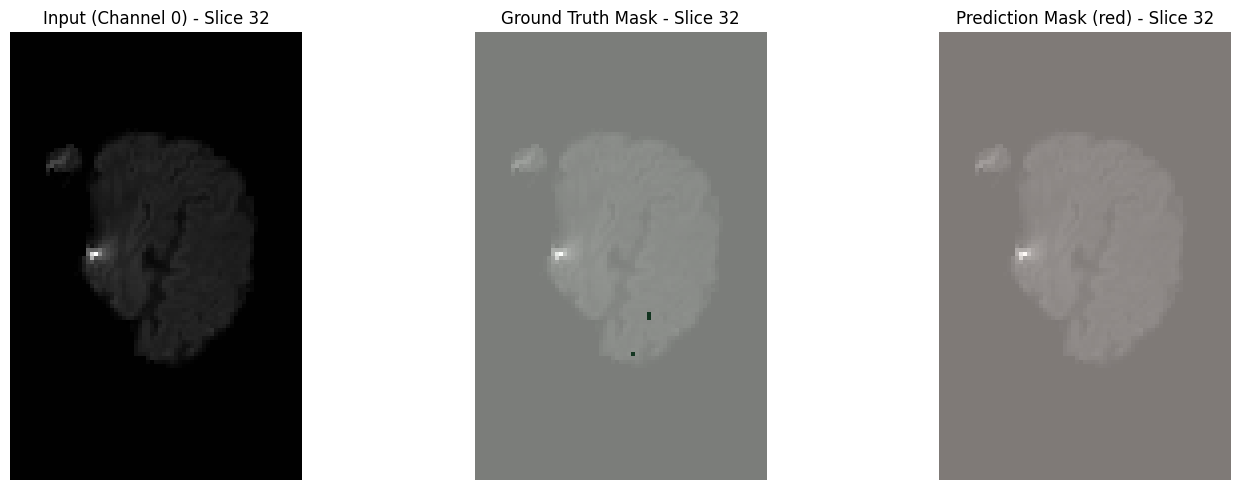

Inside plot_sample_colored function
Original shapes: x=torch.Size([2, 112, 112, 73]), y=torch.Size([1, 112, 112, 73]), pred=torch.Size([1, 112, 112, 73])
Shapes after squeezing: x=torch.Size([2, 112, 112, 73]), y=torch.Size([112, 112, 73]), pred=torch.Size([112, 112, 73])
x.ndim after squeezing: 4
pred.ndim after squeezing: 3
slice_idx: 32
Entering x.ndim == 4 block
  Assigned pred_slice using pred[32]. Shape: torch.Size([112, 73])
  slice_idx: 32, img_slice shape: torch.Size([112, 73])
  y_slice shape in ndim 4 block: torch.Size([112, 73])
Value of pred_slice before comparison: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
img assigned from img_slice.
Prediction slice values before thresholding: Unique values=tensor([0.]), min=0.0, max=0.0, mean=0.0
Ground Truth mask values before

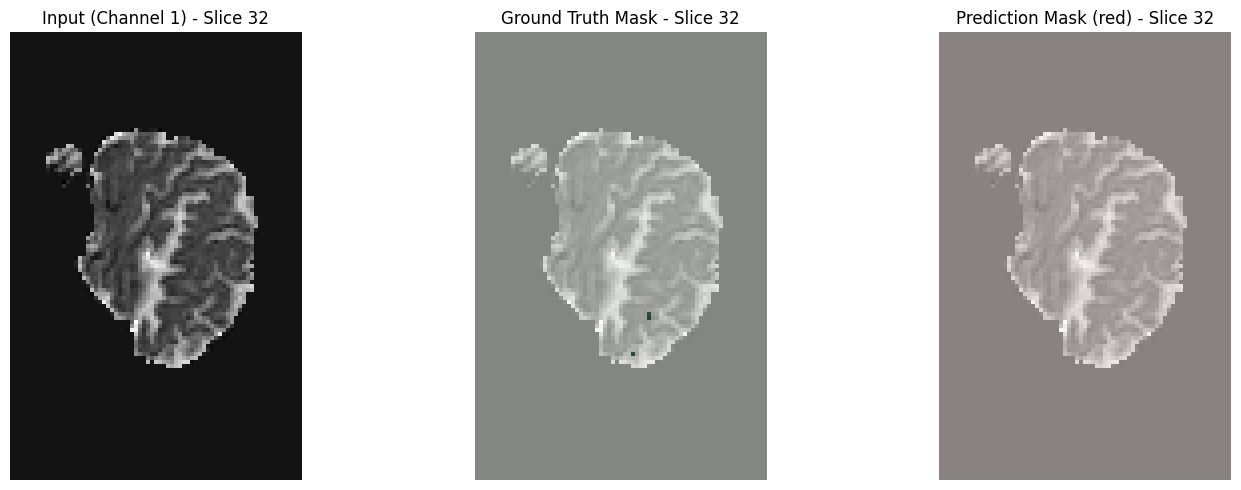

In [16]:

# **Step 5: Load All Trained Models and Perform Ensemble Prediction**
# %%
print(f"# Loading All Trained Models from model_paths_dict for Ensemble Prediction")

# Helper function to get models from smp
def get_smp_model(arch, encoder_name, in_channels, out_classes):
    if arch == "unet":
        model = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights="imagenet",
            in_channels=in_channels,
            classes=out_classes,
            encoder_depth=5,
            decoder_channels=[256, 128, 64, 32, 16]
        )
    elif arch == "unetplusplus":
         model = smp.UnetPlusPlus(
            encoder_name=encoder_name,
            encoder_weights="imagenet",
            in_channels=in_channels,
            classes=out_classes,
            encoder_depth=5,
            decoder_channels=[256, 128, 64, 32, 16]
        )
    elif arch == "deeplabv3plus":
        model = smp.DeepLabV3Plus(
            encoder_name=encoder_name,
            encoder_weights="imagenet",
            in_channels=in_channels,
            classes=out_classes,
            encoder_output_stride=16
        )
    elif arch == "linknet":
         model = smp.Linknet(
            encoder_name=encoder_name,
            encoder_weights="imagenet",
            in_channels=in_channels,
            classes=out_classes
        )
    else:
        raise ValueError(f"Unsupported architecture from smp: {arch}")

    return model
model_architectures = {
    "unet_resnet18": {"arch": "unet", "encoder_name": "resnet18"},
    "deeplabv3plus_resnet50": {"arch": "deeplabv3plus", "encoder_name": "resnet50"},
    "unetplusplus_resnet34": {"arch": "unetplusplus", "encoder_name": "resnet34"},
    # You can add more or different models here
    # "unet_resnet34": {"arch": "unet", "encoder_name": "resnet34"},
     "linknet_resnet18": {"arch": "linknet", "encoder_name": "resnet18"}
}
# Define the base path to your Google Drive
DRIVE_PATH = "/content/drive/My Drive/"

# Initialize model_paths_dict if it doesn't exist
if 'model_paths_dict' not in globals():
    model_paths_dict = {}

# Assign the specified model paths to model_paths_dict
model_paths_dict["unet_resnet18"] = [os.path.join(DRIVE_PATH, "unet_resnet18_new_model_0.pth")]
model_paths_dict["unetplusplus_resnet34"] = [os.path.join(DRIVE_PATH, "unetplusplus_resnet34_new_model_0.pth")]
model_paths_dict["deeplabv3plus_resnet50"] = [os.path.join(DRIVE_PATH, "deeplabv3plus_resnet50_new_model_0.pth")]
model_paths_dict["linknet_resnet18"] = [os.path.join(DRIVE_PATH, "linknet_resnet18_new_model_0.pth")]

# You can print the dictionary to verify
print("model_paths_dict after assignment:")
print(model_paths_dict)
all_loaded_models = []
train_dataset = ISLESDataset3D(
    root_dir=DATA_DIR)
sample_x, sample_y = train_dataset[0]
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0, # Set to 0 for Colab, higher on systems with multiprocessing
    collate_fn=pad_collate
)

import matplotlib.pyplot as plt
import numpy as np
import warnings
import torch

def ensemble_predict_slice_by_slice(models, x_3d, target_shape_3d):
        # ... (previous code) ...
        with torch.no_grad():
            batch_predictions = []
            for b in range(x_3d.shape[0]):
                 volume_predictions = []
                 for d in range(x_3d.shape[2]):
                     x_slice = x_3d[b:b+1, :, d:d+1, :, :].to(DEVICE, dtype=torch.float)
                     x_slice = x_slice.squeeze(2)

                     required_divisor = 32
                     h, w = x_slice.shape[2:]
                     new_h = (h + required_divisor - 1) // required_divisor * required_divisor
                     new_w = (w + required_divisor - 1) // required_divisor * required_divisor
                     target_padded_shape_slice = (new_h, new_w)

                     x_slice_padded = pad_or_crop_to_shape_2d(x_slice, target_padded_shape_slice)


                     aligned_preds_slice = []
                     for i, model in enumerate(models):
                         try:
                             model.to(x_slice_padded.device)
                             out_slice = model(x_slice_padded)

                             # --- Add Sigmoid Activation ---
                             out_slice = torch.sigmoid(out_slice)
                             # --- End of Add Sigmoid Activation ---

                             while out_slice.ndim < 4:
                                 out_slice = out_slice.unsqueeze(0)

                             target_spatial_shape_slice_for_alignment = target_shape_3d[1:]
                             out_slice_aligned = pad_or_crop_to_shape_2d(out_slice, target_spatial_shape_slice_for_alignment)

                             aligned_preds_slice.append(out_slice_aligned)
                         except Exception as e:
                             print(f"Error predicting with model {i} on slice d={d}, batch b={b}: {e}")
                             continue

                     if not aligned_preds_slice:
                         print(f"Error: aligned_preds_slice is empty for batch {b}, slice {d}. Skipping stacking for this slice.")
                         if target_shape_3d:
                              h_target, w_target = target_shape_3d[1:]
                              dummy_slice = torch.zeros(1, 1, 1, h_target, w_target, device=DEVICE, dtype=torch.float)
                              volume_predictions.append(dummy_slice)
                         else:
                             print("Cannot append dummy slice: target_shape_3d is not available.")

                     else:
                          stacked_slice = torch.stack(aligned_preds_slice, dim=0)
                          avg_slice = torch.mean(stacked_slice, dim=0)
                          avg_slice = avg_slice.unsqueeze(2)
                          volume_predictions.append(avg_slice)


                 if volume_predictions:
                     volume_predictions = torch.cat(volume_predictions, dim=2)
                     batch_predictions.append(volume_predictions)
                 else:
                     print(f"Warning: No volume predictions for batch {b}. Skipping batch.")


            if batch_predictions:
                 averaged_probs_batch = torch.cat(batch_predictions, dim=0)

                 print("Averaged probabilities min/max:", averaged_probs_batch.min().item(), averaged_probs_batch.max().item())

                 # The thresholding for the final mask should now work correctly with probabilities
                 final_mask_batch = (averaged_probs_batch > 0.5).float()

                 return final_mask_batch, averaged_probs_batch
            else:
                 print("Error: batch_predictions is empty. Returning None or handling appropriately.")
                 return None, None

def plot_sample_colored(x, y, pred, channel=0, slice_idx=None):
    print("Inside plot_sample_colored function")

    x_orig_shape = x.shape
    y_orig_shape = y.shape
    pred_orig_shape = pred.shape

    x = x.cpu().squeeze()
    y = y.cpu().squeeze()
    pred = pred.cpu().squeeze()

    print(f"Original shapes: x={x_orig_shape}, y={y_orig_shape}, pred={pred_orig_shape}")
    print(f"Shapes after squeezing: x={x.shape}, y={y.shape}, pred={pred.shape}")
    print(f"x.ndim after squeezing: {x.ndim}")
    print(f"pred.ndim after squeezing: {pred.ndim}") # Added print
    print(f"slice_idx: {slice_idx}") # Added print


    img_slice = None
    y_slice = None
    pred_slice = None

    if x.ndim == 4:
        print("Entering x.ndim == 4 block")
        if slice_idx is None:
             slice_idx = x.shape[1] // 2
        img_slice = x[channel, slice_idx]
        y_slice = y[slice_idx] if y.ndim > 2 else y

        # --- More robust assignment of pred_slice ---
        try:
            if pred.ndim > 2:
                pred_slice = pred[slice_idx]
                print(f"  Assigned pred_slice using pred[{slice_idx}]. Shape: {pred_slice.shape if pred_slice is not None else 'None'}") # Added print
            else:
                pred_slice = pred
                print(f"  Assigned pred_slice using pred. Shape: {pred_slice.shape if pred_slice is not None else 'None'}") # Added print
        except Exception as e:
            print(f"Error during pred_slice assignment in ndim 4 block: {e}") # Added error print
            pred_slice = None # Explicitly set to None on error
        # --- End of robust assignment ---

        print(f"  slice_idx: {slice_idx}, img_slice shape: {img_slice.shape if img_slice is not None else 'None'}")
        print(f"  y_slice shape in ndim 4 block: {y_slice.shape if y_slice is not None else 'None'}")


    elif x.ndim == 3:
         print("Entering x.ndim == 3 block")
         img_slice = x[channel]
         y_slice = y if y.ndim == 2 else y.squeeze()

         try:
             if pred.ndim > 2:
                 pred_slice = pred.squeeze()
                 print(f"  Assigned pred_slice using pred.squeeze(). Shape: {pred_slice.shape if pred_slice is not None else 'None'}") # Added print
             else:
                 pred_slice = pred
                 print(f"  Assigned pred_slice using pred. Shape: {pred_slice.shape if pred_slice is not None else 'None'}") # Added print
         except Exception as e:
             print(f"Error during pred_slice assignment in ndim 3 block: {e}") # Added error print
             pred_slice = None

         slice_idx = slice_idx if slice_idx is not None else "N/A (single slice)"
         print(f"  channel: {channel}, img_slice shape: {img_slice.shape if img_slice is not None else 'None'}")
         print(f"  y_slice shape in ndim 3 block: {y_slice.shape if y_slice is not None else 'None'}")


    elif x.ndim == 2 and y.ndim == 2 and pred.ndim == 2:
         print("Entering x.ndim == 2 block")
         img_slice = x
         y_slice = y
         pred_slice = pred # Assuming pred is already a 2D slice

         slice_idx = slice_idx if slice_idx is not None else "N/A (single slice)"
         print(f"  img_slice shape: {img_slice.shape if img_slice is not None else 'None'}")
         print(f"  y_slice shape in ndim 2 block: {y_slice.shape if y_slice is not None else 'None'}")
         print(f"  pred_slice shape in ndim 2 block: {pred_slice.shape if pred_slice is not None else 'None'}") # Added print

    else:
        print("Entering else (unsupported shape) block")
        raise ValueError(f"Unsupported input shapes for plotting after squeezing: x={x.shape}, y={y.shape}, pred={pred.shape}")

    # --- Explicit check for pred_slice here ---
    print(f"Value of pred_slice before comparison: {pred_slice}") # Added print
    if pred_slice is None:
         raise UnboundLocalError("pred_slice is None after conditional assignments.")
    # --- End of explicit check ---


    if img_slice is None or y_slice is None: # pred_slice is checked explicitly above
         raise ValueError("img_slice or y_slice was not assigned in plot_sample_colored. Check input dimensions.")


    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    try:
        img = img_slice
        print("img assigned from img_slice.")
    except Exception as e:
        print(f"Error during img = img_slice: {e}")
        raise

    # --- Add these inspection prints for prediction slice ---
    print(f"Prediction slice values before thresholding: Unique values={torch.unique(pred_slice)}, min={pred_slice.min()}, max={pred_slice.max()}, mean={pred_slice.mean()}")
    # --- End of inspection prints ---


    # --- Add this check and potential adjustment for mask values ---
    print(f"Ground Truth mask values before plotting: Unique values={torch.unique(y_slice)}, min={y_slice.min()}, max={y_slice.max()}")
    # Ensure ground truth mask is binary (0 or 1) and of float type for plotting
    y_slice_display = (y_slice > 0).float()
    print(f"Ground Truth mask values after processing for display: Unique values={torch.unique(y_slice_display)}, min={y_slice_display.min()}, max={y_slice_display.max()}")

    print(f"Prediction mask values before plotting: Unique values={torch.unique(pred_slice)}, min={pred_slice.min()}, max={pred_slice.max()}") # This is a repeat, but useful to keep near binarization
    # Ensure prediction mask is binary (0 or 1) and of float type for plotting
    pred_slice_display = (pred_slice > 0.5).float() # Using 0.5 threshold for prediction
    print(f"Prediction mask values after processing for display: Unique values={torch.unique(pred_slice_display)}, min={pred_slice_display.min()}, max={pred_slice_display.max()}")
    # --- End of check and adjustment ---


    try:
        print(f"Checking img dtype: {img.dtype}")
        img_dtype_np = img.dtype.numpy() if hasattr(img.dtype, 'numpy') else img.dtype
        print("img_dtype_np created successfully.")
    except Exception as e:
         print(f"Error converting img dtype to numpy or during hasattr: {e}")
         raise

    try:
        print(f"Checking img min/max: {img.min()}, {img.max()}")
        if not (np.issubdtype(img_dtype_np, np.floating) and img.min() >= 0 and img.max() <= 1) and \
           not (np.issubdtype(img_dtype_np, np.integer) and img.min() >= 0 and img.max() <= 255):
           warnings.warn("Image data does not appear to be in expected range [0, 1] (float) or [0, 255] (uint8) for imshow. Normalization might be off or data has unexpected values.")
        print("Warning check passed or warning issued.")
    except Exception as e:
        print(f"Error during warning check: {e}")
        pass


    try:
        print("Attempting to plot Input image.")
        img_display = (img - img.min()) / (img.max() - img.min() + 1e-8)
        axes[0].imshow(img_display, cmap='gray')
        axes[0].set_title(f"Input (Channel {channel}) - Slice {slice_idx}")
        axes[0].axis('off')
        print("Input image plotted.")
    except Exception as e:
        print(f"Error plotting Input image: {e}")
        raise

    try:
        print("Attempting to plot Ground Truth mask.")
        axes[1].imshow(img_display, cmap='gray')
        axes[1].imshow(y_slice_display, cmap='Greens', alpha=0.5)
        axes[1].set_title(f"Ground Truth Mask - Slice {slice_idx}")
        axes[1].axis('off')
        print("Ground Truth mask plotted.")
    except Exception as e:
         print(f"Error plotting Ground Truth mask: {e}")
         raise


    try:
        print("Attempting to plot Prediction mask.")
        axes[2].imshow(img_display, cmap='gray')
        axes[2].imshow(pred_slice_display, cmap='Reds', alpha=0.5)
        axes[2].set_title(f"Prediction Mask (red) - Slice {slice_idx}")
        axes[2].axis('off')
        print("Prediction mask plotted.")
    except Exception as e:
        print(f"Error plotting Prediction mask: {e}")
        raise


    plt.tight_layout()
    plt.show()

# Iterate through the model_paths_dict to load models from all categories
# This assumes model_paths_dict is populated from previous training steps.
if 'model_paths_dict' not in globals() or not model_paths_dict:
     print("Error: 'model_paths_dict' is not populated. Please ensure models were trained and saved.")
else:
    for model_name, paths in model_paths_dict.items():
        print(f"Loading models for: {model_name}")
        if model_name not in model_architectures:
             print(f"Warning: Configuration for '{model_name}' not found in model_architectures. Cannot recreate model structure. Skipping.")
             continue

        config = model_architectures[model_name]
        arch_name = config["arch"]
        encoder_name = config["encoder_name"]

        for path in paths:
            try:
                # Recreate the model structure using the retrieved config
                model = get_smp_model(
                     arch=arch_name,
                     encoder_name=encoder_name,
                     in_channels=2, # DWI and ADC (assuming these are your input channels)
                     out_classes=1  # Binary segmentation
                ).to(DEVICE)
                # Load the state dictionary
                model.load_state_dict(torch.load(path, map_location=DEVICE))
                model.eval() # Set model to evaluation mode
                all_loaded_models.append(model)
                print(f"Loaded model from {path}")
            except Exception as e:
                print(f"Error loading model from {path}: {e}")
                continue # Skip loading this model if there's an error

print(f"Total models loaded for ensemble prediction: {len(all_loaded_models)}")

# **Step 6: Ensemble Prediction and Visualization**
# %%
print(f"# Ensemble prediction on a batch and visualization (using all loaded models)")

# Get a batch from the DataLoader for prediction
try:
    x_batch, y_batch = next(iter(train_loader)) # Use generic names as it's for combined ensemble
except StopIteration:
    print("No data in train_loader. Check dataset or batch size.")
    x_batch, y_batch = None, None

if x_batch is not None and all_loaded_models: # Ensure data and models are available
    print("Input batch min/max:", x_batch.min(), x_batch.max())
    print("Mask batch unique values:", torch.unique(y_batch))

    x_batch = x_batch.to(DEVICE, dtype=torch.float)
    y_batch = y_batch.to(DEVICE, dtype=torch.float)

    target_spatial_shape_3d = y_batch.shape[2:]

    # Perform ensemble prediction using all loaded models
    final_ensemble_mask, averaged_ensemble_probs = ensemble_predict_slice_by_slice(all_loaded_models, x_batch, target_spatial_shape_3d)

    if final_ensemble_mask is not None:
        sample_index_to_plot = 0 # Choose which sample in the batch to plot
        dwi_channel = 0
        adc_channel = 1

        # --- Find a slice with a mask ---
        slice_index_with_mask = None
        # Assuming y_batch is [B, 1, D, H, W]
        ground_truth_volume = y_batch[sample_index_to_plot, 0] # Get the 3D mask for the sample [D, H, W]

        print(f"Searching for a slice with a mask in sample {sample_index_to_plot}...")
        for d in range(ground_truth_volume.shape[0]): # Iterate through depth
            mask_slice = ground_truth_volume[d]
            if torch.sum(mask_slice) > 0: # Check if there are any non-zero pixels in the slice
                slice_index_with_mask = d
                print(f"Found slice with mask at depth index: {slice_index_with_mask}")
                break # Stop searching once a slice with a mask is found

        if slice_index_with_mask is not None:
            slice_index_to_plot = slice_index_with_mask
            print(f"Plotting results for sample {sample_index_to_plot}, using slice with mask: {slice_index_to_plot}")

            # Plotting DWI input, GT, and Ensemble Prediction for the found slice
            plot_sample_colored(
                x_batch[sample_index_to_plot],
                y_batch[sample_index_to_plot],
                final_ensemble_mask[sample_index_to_plot],
                channel=dwi_channel,
                slice_idx=slice_index_to_plot
            )

            # Optionally, plot ADC input, GT, and Ensemble Prediction as well
            plot_sample_colored(
                x_batch[sample_index_to_plot],
                y_batch[sample_index_to_plot],
                final_ensemble_mask[sample_index_to_plot],
                channel=adc_channel,
                slice_idx=slice_index_to_plot
            )

        else:
            print(f"No slices with a mask found in sample {sample_index_to_plot}. Cannot plot a slice with a visible ground truth mask.")
            # Optionally, plot a default slice anyway, but inform the user it has no mask
            # slice_index_to_plot = final_ensemble_mask.shape[2] // 2 # Default to middle slice
            # print(f"No mask found in sample {sample_index_to_plot}. Plotting middle slice {slice_index_to_plot} anyway.")
            # plot_sample_colored(...) # Call plotting with the default slice
        # --- End of finding slice with mask ---


    else:
        print("Ensemble prediction failed.")

else:
    if x_batch is None:
         print("Skipping ensemble prediction as no data batch was loaded.")
    if not all_loaded_models:
         print("Skipping ensemble prediction as no models were loaded.")

In [17]:
# %% Boosting Ensemble Training (Simplified Sequential)
print(f"#Training Boosting Ensemble Base Models (Simplified Sequential)")

boosting_models = []
N_BOOSTING_MODELS = 3 # Number of models in the boosting sequence
BOOSTING_MODEL_CONFIG = "unet_resnet18_config1" # Use one specific configuration for boosting

# You will need a way to calculate sample/pixel weights based on previous model errors.
# This is a conceptual placeholder.
def calculate_error_weights(ground_truth, previous_model_predictions):
    # Implement logic to calculate weights based on where the previous model
    # made errors or was uncertain.
    # Example: weights could be higher for misclassified pixels.
    # This would require running inference on the training data after each boosting step.
    return torch.ones_like(ground_truth).to(ground_truth.device) # Placeholder: uniform weights


# Define the model configurations for the boosting ensemble
model_configurations = {
    "unet_resnet18": {"arch": "unet", "encoder_name": "resnet18"},
    "deeplabv3plus_resnet50": {"arch": "deeplabv3plus", "encoder_name": "resnet50"},
    "unetplusplus_resnet34": {"arch": "unetplusplus", "encoder_name": "resnet34"},
    "linknet_resnet18": {"arch": "linknet", "encoder_name": "resnet18"}
}

# Choose which configuration to use for the boosting models
BOOSTING_MODEL_CONFIG = "unet_resnet18" # Example: Use the UNet with ResNet18 encoder

# --- Your boosting training loop starts here ---
# ...
for i in range(N_BOOSTING_MODELS):
    print(f"Training Boosting model {i+1}/{N_BOOSTING_MODELS}")

    # Get model (using smp helper or custom 3D model) - use the same architecture
    config = model_configurations[BOOSTING_MODEL_CONFIG]
    # ... rest of your boosting code ...


for i in range(N_BOOSTING_MODELS):
    print(f"  Training Boosting model {i+1}/{N_BOOSTING_MODELS}")

    # Get model (using smp helper or custom 3D model) - use the same architecture
    config = model_configurations[BOOSTING_MODEL_CONFIG]
    try:
         if config["arch"] in ["unet", "unetplusplus", "deeplabv3plus", "linknet"]: # smp models
             model = get_smp_model(arch=config["arch"], encoder_name=config["encoder_name"], in_channels=2, out_classes=1).to(DEVICE)
         # elif config["arch"] == "unet3d": # Custom 3D model
         #      model = UNet3D(...).to(DEVICE) # Initialize your 3D model
         else:
              raise ValueError(f"Unknown architecture: {config['arch']}")
    except Exception as e:
        print(f"Error creating boosting model {i+1}: {e}")
        continue # Skip to the next model instance


    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = dice_loss # You might use a weighted loss

    # --- Training Loop (Slice-by-Slice if using smp) ---
    # This will be similar to the bagging training loop, but you'll need
    # to incorporate error weights if you implement weighted training.

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for batch_idx, (x_3d, y_3d) in enumerate(train_loader):
             x_3d = x_3d.to(DEVICE, dtype=torch.float)
             y_3d = y_3d.to(DEVICE, dtype=torch.float)

             # Calculate error weights based on the previous model's predictions (if i > 0)
             # This part is complex and requires running inference on the training data
             # with the previously trained model.
             # For this simplified example, we'll use uniform weights for now.
             error_weights = calculate_error_weights(y_3d, None) # Placeholder


             # --- Slice-by-Slice Processing (if using smp) ---
             batch_losses = []
             for d in range(x_3d.shape[2]):
                 x_slice = x_3d[:, :, d, :, :].clone() # Get slice
                 y_slice = y_3d[:, :, d, :, :].clone() # Get slice
                 weights_slice = error_weights[:, :, d, :, :].clone() # Get corresponding weights slice


                 # Padding for divisibility
                 required_divisor = 32
                 h, w = x_slice.shape[2:]
                 new_h = (h + required_divisor - 1) // required_divisor * required_divisor
                 new_w = (w + required_divisor - 1) // required_divisor * required_divisor
                 target_padded_shape_slice = (new_h, new_w)

                 x_slice_padded = pad_or_crop_to_shape_2d(x_slice, target_padded_shape_slice)
                 y_slice_padded = pad_or_crop_to_shape_2d(y_slice, target_padded_shape_slice)
                 weights_slice_padded = pad_or_crop_to_shape_2d(weights_slice, target_padded_shape_slice)


                 optimizer.zero_grad()
                 out_slice = model(x_slice_padded)

                 # Align output for loss
                 target_spatial_shape_slice_for_loss = y_slice.shape[2:]
                 out_slice_aligned_for_loss = pad_or_crop_to_shape_2d(out_slice, target_spatial_shape_slice_for_loss)

                 # Use a weighted loss function
                 # You would need to implement a weighted Dice Loss or similar
                 # For this example, using regular Dice Loss
                 loss = criterion(out_slice_aligned_for_loss, y_slice) # Use y_slice for loss
                 # loss = weighted_dice_loss(out_slice_aligned_for_loss, y_slice_padded, weights_slice_padded) # If using weighted loss


                 loss.backward()
                 batch_losses.append(loss.item())

             # --- End of Slice-by-Slice Processing ---

             # If using a 3D model:
             # error_weights_3d = calculate_error_weights(y_3d, previous_model_predictions_3d)
             # optimizer.zero_grad()
             # out_3d = model(x_3d)
             # loss = weighted_dice_loss_3d(out_3d, y_3d, error_weights_3d) # Need a 3D weighted loss
             # loss.backward()


        optimizer.step()
        total_loss += np.mean(batch_losses)

        if batch_idx % 10 == 0:
            print(f"    Batch {batch_idx}/{len(train_loader)} Avg Slice Loss: {np.mean(batch_losses):.4f}")

    print(f"  Epoch {epoch+1} Avg Slice Loss: {total_loss / len(train_loader):.4f}")

    # After training, save the boosting model instance
    save_path = f"boosting_{BOOSTING_MODEL_CONFIG.replace(' ', '_')}_instance_{i}.pth"
    torch.save(model.state_dict(), save_path)
    boosting_models.append({"path": save_path, "config_name": BOOSTING_MODEL_CONFIG}) # Store path and config name
    print(f"  Saved {save_path}")

    # Important for boosting: After training a model, you need to run inference
    # on the *entire* training dataset with this model to calculate the error weights
    # for the *next* boosting model. This requires another inference loop over the
    # training data, which can be time-consuming.
    # For this conceptual example, we are skipping the actual error weight calculation.



#Training Boosting Ensemble Base Models (Simplified Sequential)
Training Boosting model 1/3
Training Boosting model 2/3
Training Boosting model 3/3
  Training Boosting model 1/3
  Epoch 1 Avg Slice Loss: 0.0080
  Saved boosting_unet_resnet18_instance_0.pth
  Training Boosting model 2/3
  Epoch 1 Avg Slice Loss: 0.0080
  Saved boosting_unet_resnet18_instance_1.pth
  Training Boosting model 3/3
  Epoch 1 Avg Slice Loss: 0.0081
  Saved boosting_unet_resnet18_instance_2.pth


#Boosting Ensemble Prediction
  Loaded boosting model from boosting_unet_resnet18_instance_0.pth
  Loaded boosting model from boosting_unet_resnet18_instance_1.pth
  Loaded boosting model from boosting_unet_resnet18_instance_2.pth
Number of loaded boosting models: 3
Input batch min/max: tensor(-2.2712) tensor(1806.6217)
Mask batch unique values: tensor([0., 1.])
# Boosting Ensemble prediction on a batch
Averaged probabilities min/max: 0.0 1.0
Averaged probabilities min/max: 0.0 1.0
Boosting Ensemble Dice Score: 0.0032
Inside plot_sample_colored function
Original shapes: x=torch.Size([2, 256, 256, 73]), y=torch.Size([1, 256, 256, 73]), pred=torch.Size([1, 256, 256, 73])
Shapes after squeezing: x=torch.Size([2, 256, 256, 73]), y=torch.Size([256, 256, 73]), pred=torch.Size([256, 256, 73])
x.ndim after squeezing: 4
pred.ndim after squeezing: 3
slice_idx: None
Entering x.ndim == 4 block
  Assigned pred_slice using pred[128]. Shape: torch.Size([256, 73])
  slice_idx: 128, img_slice shape: to

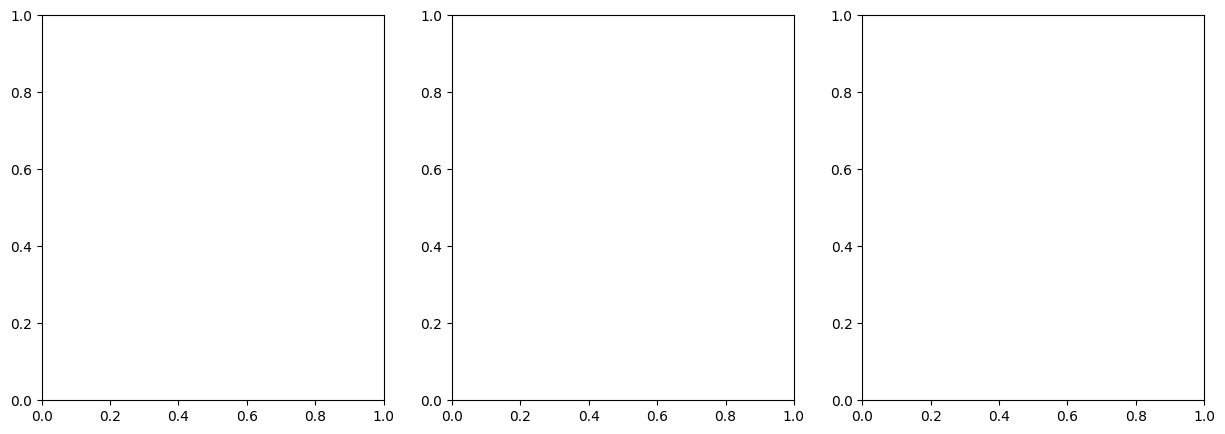

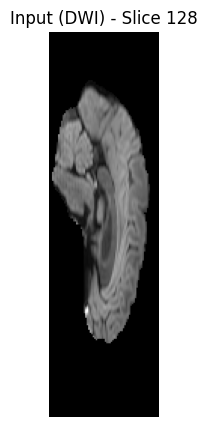

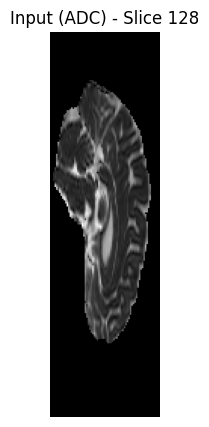

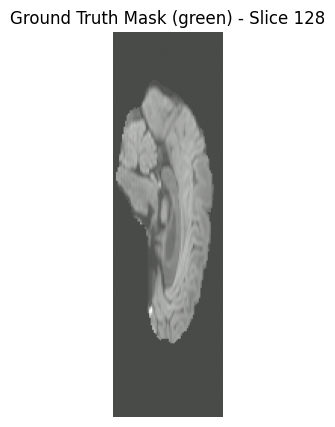

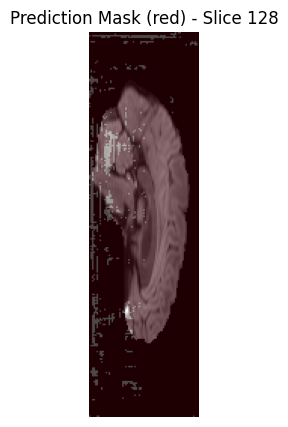

In [28]:

# %% Boosting Ensemble Prediction
print(f"#Boosting Ensemble Prediction")



# Boosting ensemble prediction typically involves a weighted sum of the base model predictions.
# The weights for each base model are usually determined during the boosting training process
# (e.g., based on their performance).

# For simplicity, we can illustrate with simple averaging or equal weighting for now.
# A more proper boosting prediction would use learned weights.

# Load boosting models from paths
loaded_boosting_models = []
for model_info in boosting_models:
     path = model_info["path"]
     config_name = model_info["config_name"]

     try:
         # Find the original configuration from model_configurations
         original_config = model_configurations.get(config_name)

         if original_config:
              if original_config["arch"] in ["unet", "unetplusplus", "deeplabv3plus", "linknet"]: # smp models
                 model = get_smp_model(arch=original_config["arch"], encoder_name=original_config["encoder_name"], in_channels=2, out_classes=1).to(DEVICE)
             # elif original_config["arch"] == "unet3d": # Custom 3D model
             #      model = UNet3D(...).to(DEVICE)
              else:
                   print(f"Unknown architecture in saved path: {original_config['arch']}")
                   continue

              model.load_state_dict(torch.load(path, map_location=DEVICE))
              model.eval()
              loaded_boosting_models.append(model)
              print(f"  Loaded boosting model from {path}")
         else:
             print(f"  Could not find configuration for saved model path: {path}")
             continue

     except Exception as e:
         print(f"  Error loading boosting model from {path}: {e}")
         continue

print(f"Number of loaded boosting models: {len(loaded_boosting_models)}")

# Get a batch from the DataLoader for prediction
# Using train_loader here for demonstration, replace with a validation/test loader
try:
    x_batch_bagging, y_batch_bagging = next(iter(train_loader))
except StopIteration:
    print("No data in train_loader. Check dataset or batch size.")
    x_batch_bagging, y_batch_bagging = None, None # Handle empty loader

if x_batch_bagging is not None:
    print("Input batch min/max:", x_batch_bagging.min(), x_batch_bagging.max())
    print("Mask batch unique values:", torch.unique(y_batch_bagging))

    # Ensure correct dims and type for prediction and move to device
    x_batch_bagging = x_batch_bagging.to(DEVICE, dtype=torch.float)
    y_batch_bagging = y_batch_bagging.to(DEVICE, dtype=torch.float) # Also move target mask to device

    # Define the target shape for alignment - this should match the shape expected by your padding/cropping functions
    # You might need to determine this based on your data and pad_collate output
    target_spatial_shape_3d_bagging = y_batch_bagging.shape[2:] # Example: Assuming y_batch_bagging is [B, 1, D, H, W]

    # --- Your boosting ensemble prediction code starts here ---
    print(f"# Boosting Ensemble prediction on a batch")

    # Use ensemble_predict_slice_by_slice (or a similar function) for prediction
    # This will average the predictions of the loaded boosting models.
    final_boosting_mask, averaged_boosting_probs = ensemble_predict_slice_by_slice(loaded_boosting_models, x_batch_bagging, target_spatial_shape_3d_bagging)
    # ... rest of your boosting evaluation code ...
else:
    print("Skipping boosting ensemble prediction as no data batch was loaded.")

if len(loaded_boosting_models) > 0:
    # Use ensemble_predict_slice_by_slice (or a similar function) for prediction
    # This will average the predictions of the loaded boosting models.
    final_boosting_mask, averaged_boosting_probs = ensemble_predict_slice_by_slice(loaded_boosting_models, x_batch_bagging, target_spatial_shape_3d_bagging) # Reuse batch from bagging

    # Evaluate Boosting Ensemble prediction
    boosting_dice = dice_score(final_boosting_mask, safe_unsqueeze_mask(y_batch_bagging.to(DEVICE)))
    print(f"Boosting Ensemble Dice Score: {boosting_dice:.4f}")

    # Plot Boosting Ensemble prediction for a sample
    plot_sample_colored(x_batch_bagging[0], y_batch_bagging[0], final_boosting_mask[0], channel=0)
    plot_sample_separate_modalities(x_batch_bagging[0], y_batch_bagging[0], final_boosting_mask[0])

else:
     print("No boosting models were loaded for prediction.")

A more common and practical approach for boosting with neural networks is Gradient Boosting, often implemented using frameworks like LightGBM or XGBoost. However, these are usually applied to tabular data or features extracted from images, not directly to the raw image data within the neural network training loop in the same way you're training your UNet/VNet.

Implementing true boosting directly with your existing PyTorch models would be quite complex. A simplified approach that captures the spirit of boosting with neural networks might involve:

Train a base model.
Identify pixels where the base model made incorrect predictions.
Train a second model, giving higher weight or focus to the misclassified pixels from the first model's predictions.
Combine the predictions of the models, often with weights.
This is still a significant departure from your current training loop.

Given the context of your existing code and the complexity of true boosting with deep learning architectures, a more feasible approach that aligns with your current structure would be to adapt a method that mimics some aspects of boosting or sequential training, but within the framework of your existing models.

One way to do this is to train models sequentially, and in each subsequent training phase, somehow influence the training data or loss function based on the errors of the previous model.

Here's a conceptual outline and some code snippets to illustrate this simplified "sequential error focus" approach using your existing UNet3D model. This is NOT a true AdaBoost or Gradient Boosting implementation but aims to show a sequential training process where later models pay more attention to areas where earlier models struggled.

Conceptual Steps:

Train the first UNet3D model on the full dataset.
After training the first model, evaluate its performance on the training data to identify pixels where it performed poorly (e.g., where the predicted probability was close to 0.5 for the incorrect class).
Create a weighting mask based on these errors. Pixels where the first model was uncertain or wrong get higher weights.
Train a second UNet3D model, incorporating this weighting mask into the loss function (e.g., using a weighted Dice Loss). This encourages the second model to focus more on the challenging pixels.
Optionally, repeat for more models.
Combine the predictions of the models (e.g., weighted averaging).

In [ ]:
# %% Stacking Ensemble Training - Base Models
print(f"#Training Stacking Ensemble Base Models")

stacking_base_models = {}
N_STACKING_BASE_MODELS = 1 # Train one instance of each configuration for stacking

for model_name, config in model_configurations.items():
    stacking_base_models[model_name] = []
    print(f"  Training Stacking base model {model_name}")

    # Get model
    try:
         if config["arch"] in ["unet", "unetplusplus", "deeplabv3plus", "linknet"]: # smp models
             model = get_smp_model(arch=config["arch"], encoder_name=config["encoder_name"], in_channels=2, out_classes=1).to(DEVICE)
         # elif config["arch"] == "unet3d": # Custom 3D model
         #      model = UNet3D(...).to(DEVICE)
         else:
              raise ValueError(f"Unknown architecture: {config['arch']}")
    except Exception as e:
        print(f"Error creating stacking base model {model_name}: {e}")
        continue # Skip to the next model


    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = dice_loss

    # --- Training Loop (Similar to Bagging/Boosting) ---
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for batch_idx, (x_3d, y_3d) in enumerate(train_loader):
             x_3d = x_3d.to(DEVICE, dtype=torch.float)
             y_3d = y_3d.to(DEVICE, dtype=torch.float)

             # --- Slice-by-Slice Processing (if using smp) ---
             batch_losses = []
             for d in range(x_3d.shape[2]):
                 x_slice = x_3d[:, :, d, :, :].clone()
                 y_slice = y_3d[:, :, d, :, :].clone()

                 # Padding for divisibility
                 required_divisor = 32
                 h, w = x_slice.shape[2:]
                 new_h = (h + required_divisor - 1) // required_divisor * required_divisor
                 new_w = (w + required_divisor - 1) // required_divisor * required_divisor
                 target_padded_shape_slice = (new_h, new_w)

                 x_slice_padded = pad_or_crop_to_shape_2d(x_slice, target_padded_shape_slice)
                 y_slice_padded = pad_or_crop_to_shape_2d(y_slice, target_padded_shape_slice)


                 optimizer.zero_grad()
                 out_slice = model(x_slice_padded)

                 # Align output for loss
                 target_spatial_shape_slice_for_loss = y_slice.shape[2:]
                 out_slice_aligned_for_loss = pad_or_crop_to_shape_2d(out_slice, target_spatial_shape_slice_for_loss)

                 loss = criterion(out_slice_aligned_for_loss, y_slice)

                 loss.backward()
                 batch_losses.append(loss.item())

             # --- End of Slice-by-Slice Processing ---

            optimizer.step()
            total_loss += np.mean(batch_losses)

            if batch_idx % 10 == 0:
                print(f"    Batch {batch_idx}/{len(train_loader)} Avg Slice Loss: {np.mean(batch_losses):.4f}")

        print(f"  Epoch {epoch+1} Avg Slice Loss: {total_loss / len(train_loader):.4f}")

    # Save the trained base model
    save_path = f"stacking_base_{model_name.replace(' ', '_')}.pth"
    torch.save(model.state_dict(), save_path)
    stacking_base_models[model_name].append(save_path)
    print(f"  Saved {save_path}")


# %% Stacking Ensemble - Generate Meta-Features on Validation Data
print(f"#Generating Meta-Features for Stacking")

# For stacking, you need a separate validation dataset.
# This is crucial to prevent data leakage.
# Assume you have a validation loader: val_loader

# Load trained base models
loaded_stacking_base_models = {}
for model_name, paths in stacking_base_models.items():
    if paths: # Assuming only one instance per config for stacking base
        path = paths[0]
        try:
            config = model_configurations[model_name]
            if config["arch"] in ["unet", "unetplusplus", "deeplabv3plus", "linknet"]:
                 model = get_smp_model(arch=config["arch"], encoder_name=config["encoder_name"], in_channels=2, out_classes=1).to(DEVICE)
            # elif config["arch"] == "unet3d": model = UNet3D(...).to(DEVICE)
            else:
                print(f"Unknown architecture for stacking base model: {config['arch']}")
                continue

            model.load_state_dict(torch.load(path, map_location=DEVICE))
            model.eval()
            loaded_stacking_base_models[model_name] = model
            print(f"  Loaded stacking base model from {path}")
        except Exception as e:
            print(f"  Error loading stacking base model from {path}: {e}")
            continue
    else:
        print(f"  No saved model found for stacking base config: {model_name}")


# Collect predictions from base models on the validation set
# These predictions will be the meta-features for the meta-model.
# The shape of meta-features will be [num_validation_samples, num_base_models, D, H, W]
# (or D*H*W for a flattened approach).

all_base_model_val_preds = []
all_val_masks = [] # Collect validation masks to train the meta-model

# Assuming val_loader is defined and contains validation data
# for val_batch_idx, (x_val_3d, y_val_3d) in enumerate(val_loader):
#     x_val_3d = x_val_3d.to(DEVICE, dtype=torch.float)
#     y_val_3d = y_val_3d.to(DEVICE, dtype=torch.float) # Keep on device for now

#     batch_base_model_preds = []
#     for model_name, model in loaded_stacking_base_models.items():
#         print(f"    Generating predictions for stacking base model: {model_name}")
#         with torch.no_grad():
#             # Predict slice by slice (if using smp)
#             model_val_predictions = []
#             for b in range(x_val_3d.shape[0]):
#                  volume_predictions = []
#                  for d in range(x_val_3d.shape[2]):
#                      x_slice = x_val_3d[b:b+1, :, d:d+1, :, :].to(model.device, dtype=torch.float)
#                      x_slice = x_slice.squeeze(2)
#
#                      # Padding for divisibility
#                      required_divisor = 32
#                      h, w = x_slice.shape[2:]
#                      new_h = (h + required_divisor - 1) // required_divisor * required_divisor
#                      new_w = (w + required_divisor - 1) // required_divisor * required_divisor
#                      target_padded_shape_slice = (new_h, new_w)
#                      x_slice_padded = pad_or_crop_to_shape_2d(x_slice, target_padded_shape_slice)
#
#                      out_slice = model(x_slice_padded) # Get probability output
#
#                      # Align output
#                      target_spatial_shape_slice_for_alignment = y_val_3d.shape[2:] # Should be from y_val_3d
#                      out_slice_aligned = pad_or_crop_to_shape_2d(out_slice, target_spatial_shape_slice_for_alignment)
#
#                      out_slice_aligned = out_slice_aligned.unsqueeze(2) # Add depth dim back
#                      volume_predictions.append(out_slice_aligned)
#
#                  volume_predictions = torch.cat(volume_predictions, dim=2)
#                  model_val_predictions.append(volume_predictions)
#
#             model_val_predictions_batch = torch.cat(model_val_predictions, dim=0) # Predictions for the batch
#             batch_base_model_preds.append(model_val_predictions_batch)
#
#     # Stack predictions from different base models for this batch
#     # Shape: [batch_size, num_base_models, 1, D, H, W]
#     stacked_batch_preds = torch.stack(batch_base_model_preds, dim=1) # Stack along dim 1
#     all_base_model_val_preds.append(stacked_batch_preds)
#     all_val_masks.append(y_val_3d)
#
# # Concatenate all batches to get the full meta-features and masks for the validation set
# meta_features = torch.cat(all_base_model_val_preds, dim=0) # Shape: [total_val_samples, num_base_models, 1, D, H, W]
# meta_masks = torch.cat(all_val_masks, dim=0) # Shape: [total_val_samples, 1, D, H, W]
#
# # Reshape meta_features for the meta-model if needed (e.g., flatten spatial dimensions)
# # meta_features_flat = meta_features.view(meta_features.size(0), meta_features.size(1), -1) # Shape: [total_val_samples, num_base_models, D*H*W]
# # meta_masks_flat = meta_masks.view(meta_masks.size(0), -1) # Shape: [total_val_samples, D*H*W]


# %% Stacking Ensemble - Train Meta-Model
print(f"#Training Stacking Ensemble Meta-Model")

# The meta-model can be a simple model (e.g., a logistic regression, a small neural network,
# or even another segmentation model).

# Example: A simple 3D convolutional meta-model
# class MetaModel3D(nn.Module):
#     def __init__(self, in_channels=len(loaded_stacking_base_models), out_channels=1):
#         super().__init__()
#         # Example: a few conv layers
#         self.conv1 = nn.Conv3d(in_channels, 32, kernel_size=3, padding=1)
#         self.relu = nn.ReLU(inplace=True)
#         self.conv2 = nn.Conv3d(32, out_channels, kernel_size=1) # Final output layer
#
#     def forward(self, x):
#         # x will have shape [B, num_base_models, 1, D, H, W] or similar
#         # Squeeze the channel dim if needed, or adapt conv1
#         x = x.squeeze

In [ ]:
# %% Evaluate individual ensemble models
print(f"#Evaluate individual ensemble models")

# Get a batch from the DataLoader for evaluation
# Using train_loader here, ideally use a validation or test loader
try:
    x_batch_eval, y_batch_eval = next(iter(train_loader))
except StopIteration:
    print("No data in train_loader for individual model evaluation. Check dataset or batch size.")
    x_batch_eval, y_batch_eval = None, None # Handle empty loader

# Use a list to store metrics for each model
model_metrics_list = []

if x_batch_eval is not None and len(ensemble_models) > 0:
    x_batch_eval = x_batch_eval.to(DEVICE, dtype=torch.float)
    y_batch_eval = y_batch_eval.to(DEVICE, dtype=torch.float)

    # Determine the target shape for alignment - use the spatial shape of y
    target_spatial_shape_3d_eval = y_batch_eval.shape[2:]

    print(f"Evaluating {len(ensemble_models)} individual models on a batch.")

    for i, model in enumerate(ensemble_models):
        # You might need to get the original model name from model_paths_dict
        # This requires matching the model instance back to its name/path
        # For simplicity, let's use a generic name for now.
        model_name = f"Model {i+1}"
        # A more robust way would involve storing model names with instances during loading.

        print(f"  Evaluating {model_name}...")

        with torch.no_grad():
            # Perform prediction for the individual model slice by slice
            model_predictions = []
            for b in range(x_batch_eval.shape[0]): # Iterate through batch
                 volume_predictions = []
                 for d in range(x_batch_eval.shape[2]): # Iterate through depth dimension
                     x_slice = x_batch_eval[b:b+1, :, d:d+1, :, :].to(model.device, dtype=torch.float)
                     x_slice = x_slice.squeeze(2) # Remove depth dim to get [1, C, H, W]

                     # --- Add padding to make height and width divisible by the required divisor ---
                     required_divisor = 32 # Use the largest required divisor observed
                     h, w = x_slice.shape[2:]
                     new_h = (h + required_divisor - 1) // required_divisor * required_divisor
                     new_w = (w + required_divisor - 1) // required_divisor * required_divisor
                     target_padded_shape_slice = (new_h, new_w)

                     x_slice_padded = pad_or_crop_to_shape_2d(x_slice, target_padded_shape_slice)

                     out_slice = model(x_slice_padded) # Model predicts probabilities for the slice [1, 1, H, W]

                     # Ensure output slice is 4D [1, C, H, W] and align spatial dimensions
                     while out_slice.ndim < 4:
                         out_slice = out_slice.unsqueeze(0)

                     # Align the model's output to the original target spatial shape
                     target_spatial_shape_slice_for_alignment = target_spatial_shape_3d_eval[1:] # (H, W)
                     out_slice_aligned = pad_or_crop_to_shape_2d(out_slice, target_spatial_shape_slice_for_alignment)

                     # Threshold the prediction to get a binary mask for the slice
                     pred_slice_binary = (out_slice_aligned > 0.5).float()

                     # Add depth dimension back
                     pred_slice_binary = pred_slice_binary.unsqueeze(2) # [1, 1, 1, H, W]
                     volume_predictions.append(pred_slice_binary)

                 # Stack slices back to form a 3D volume prediction for the sample
                 volume_predictions = torch.cat(volume_predictions, dim=2) # Concatenate along depth [1, 1, D, H, W]
                 model_predictions.append(volume_predictions)

            # Concatenate predictions for the batch
            model_predictions_batch = torch.cat(model_predictions, dim=0) # [B, 1, D, H, W]

        # Calculate evaluation metrics for the batch prediction
        # Ensure target mask has the correct shape [B, 1, D, H, W]
        y_batch_eval_aligned = safe_unsqueeze_mask(y_batch_eval)

        # Ensure both tensors have the same spatial dimensions for metric calculation
        # This step is similar to the loss calculation alignment.
        min_spatial_shape_eval = [min(a, b) for a, b in zip(model_predictions_batch.shape[2:], y_batch_eval_aligned.shape[2:])]
        model_predictions_batch_aligned = model_predictions_batch[:, :, :min_spatial_shape_eval[0], :min_spatial_shape_eval[1], :min_spatial_shape_eval[2]]
        y_batch_eval_aligned_cropped = y_batch_eval_aligned[:, :, :min_spatial_shape_eval[0], :min_spatial_shape_eval[1], :min_spatial_shape_eval[2]]


        dice_batch = dice_score(model_predictions_batch_aligned, y_batch_eval_aligned_cropped)
        # You can add AVD and F1 here if you have those functions
        # avd_batch = absolute_volume_difference(model_predictions_batch_aligned.cpu().numpy(), y_batch_eval_aligned_cropped.cpu().numpy())
        # f1_batch = lesion_wise_f1_score(model_predictions_batch_aligned.cpu().numpy(), y_batch_eval_aligned_cropped.cpu().numpy())

        # Store the metrics in a dictionary for this model
        metrics_entry = {
            "Model": model_name,
            "Dice Score (Batch)": dice_batch.item() # Use .item() to get scalar from tensor
            # Add other metrics here
            # "AVD (Batch)": avd_batch,
            # "Lesion-wise F1 (Batch)": f1_batch
        }
        model_metrics_list.append(metrics_entry)

# %% Display Metrics Table
import pandas as pd

if model_metrics_list:
    df_metrics = pd.DataFrame(model_metrics_list)
    print("\nIndividual Model Evaluation Metrics (on a batch):")
    display(df_metrics) # Use display for a nice table in Colab

# %% Rest of your code (Ensemble prediction, visualization)
# ... (Your code for ensemble prediction and plotting) ...2

In [ ]:
# %% Evaluate individual ensemble models
print(f"#Evaluate individual ensemble models")

# Get a batch from the DataLoader for evaluation
# Using train_loader here, ideally use a validation or test loader
try:
    x_batch_eval, y_batch_eval = next(iter(train_loader))
except StopIteration:
    print("No data in train_loader for individual model evaluation. Check dataset or batch size.")
    x_batch_eval, y_batch_eval = None, None # Handle empty loader

# Use a list to store metrics for each model
model_metrics_list = []

if x_batch_eval is not None and len(ensemble_models) > 0:
    x_batch_eval = x_batch_eval.to(DEVICE, dtype=torch.float)
    y_batch_eval = y_batch_eval.to(DEVICE, dtype=torch.float)

    # Determine the target shape for alignment - use the spatial shape of y
    target_spatial_shape_3d_eval = y_batch_eval.shape[2:]

    print(f"Evaluating {len(ensemble_models)} individual models on a batch.")

    for i, model in enumerate(ensemble_models):
        # You might need to get the original model name from model_paths_dict
        # This requires matching the model instance back to its name/path
        # For simplicity, let's use a generic name for now.
        model_name = f"Model {i+1}"
        # A more robust way would involve storing model names with instances during loading.

        print(f"  Evaluating {model_name}...")

        with torch.no_grad():
            # Perform prediction for the individual model slice by slice
            model_predictions = []
            for b in range(x_batch_eval.shape[0]): # Iterate through batch
                 volume_predictions = []
                 for d in range(x_batch_eval.shape[2]): # Iterate through depth dimension
                     x_slice = x_batch_eval[b:b+1, :, d:d+1, :, :].to(model.device, dtype=torch.float)
                     x_slice = x_slice.squeeze(2) # Remove depth dim to get [1, C, H, W]

                     # --- Add padding to make height and width divisible by the required divisor ---
                     required_divisor = 32 # Use the largest required divisor observed
                     h, w = x_slice.shape[2:]
                     new_h = (h + required_divisor - 1) // required_divisor * required_divisor
                     new_w = (w + required_divisor - 1) // required_divisor * required_divisor
                     target_padded_shape_slice = (new_h, new_w)

                     x_slice_padded = pad_or_crop_to_shape_2d(x_slice, target_padded_shape_slice)

                     out_slice = model(x_slice_padded) # Model predicts probabilities for the slice [1, 1, H, W]

                     # Ensure output slice is 4D [1, C, H, W] and align spatial dimensions
                     while out_slice.ndim < 4:
                         out_slice = out_slice.unsqueeze(0)

                     # Align the model's output to the original target spatial shape
                     target_spatial_shape_slice_for_alignment = target_spatial_shape_3d_eval[1:] # (H, W)
                     out_slice_aligned = pad_or_crop_to_shape_2d(out_slice, target_spatial_shape_slice_for_alignment)

                     # Threshold the prediction to get a binary mask for the slice
                     pred_slice_binary = (out_slice_aligned > 0.5).float()

                     # Add depth dimension back
                     pred_slice_binary = pred_slice_binary.unsqueeze(2) # [1, 1, 1, H, W]
                     volume_predictions.append(pred_slice_binary)

                 # Stack slices back to form a 3D volume prediction for the sample
                 volume_predictions = torch.cat(volume_predictions, dim=2) # Concatenate along depth [1, 1, D, H, W]
                 model_predictions.append(volume_predictions)

            # Concatenate predictions for the batch
            model_predictions_batch = torch.cat(model_predictions, dim=0) # [B, 1, D, H, W]

        # Calculate evaluation metrics for the batch prediction
        # Ensure target mask has the correct shape [B, 1, D, H, W]
        y_batch_eval_aligned = safe_unsqueeze_mask(y_batch_eval)

        # Ensure both tensors have the same spatial dimensions for metric calculation
        # This step is similar to the loss calculation alignment.
        min_spatial_shape_eval = [min(a, b) for a, b in zip(model_predictions_batch.shape[2:], y_batch_eval_aligned.shape[2:])]
        model_predictions_batch_aligned = model_predictions_batch[:, :, :min_spatial_shape_eval[0], :min_spatial_shape_eval[1], :min_spatial_shape_eval[2]]
        y_batch_eval_aligned_cropped = y_batch_eval_aligned[:, :, :min_spatial_shape_eval[0], :min_spatial_shape_eval[1], :min_spatial_shape_eval[2]]


        dice_batch = dice_score(model_predictions_batch_aligned, y_batch_eval_aligned_cropped)
        # You can add AVD and F1 here if you have those functions
        # avd_batch = absolute_volume_difference(model_predictions_batch_aligned.cpu().numpy(), y_batch_eval_aligned_cropped.cpu().numpy())
        # f1_batch = lesion_wise_f1_score(model_predictions_batch_aligned.cpu().numpy(), y_batch_eval_aligned_cropped.cpu().numpy())

        # Store the metrics in a dictionary for this model
        metrics_entry = {
            "Model": model_name,
            "Dice Score (Batch)": dice_batch.item() # Use .item() to get scalar from tensor
            # Add other metrics here
            # "AVD (Batch)": avd_batch,
            # "Lesion-wise F1 (Batch)": f1_batch
        }
        model_metrics_list.append(metrics_entry)

# %% Display Metrics Table
import pandas as pd

if model_metrics_list:
    df_metrics = pd.DataFrame(model_metrics_list)
    print("\nIndividual Model Evaluation Metrics (on a batch):")
    display(df_metrics) # Use display for a nice table in Colab

# %% Rest of your code (Ensemble prediction, visualization)
# ... (Your code for ensemble prediction and plotting) ...